<div class="alert alert-block alert-info" style="margin-top: 20px">
 <a href="http://cocl.us/pytorch_link_top"><img src = "http://cocl.us/Pytorch_top" width = 950, align = "center"></a>

<img src = "https://ibm.box.com/shared/static/ugcqz6ohbvff804xp84y4kqnvvk3bq1g.png" width = 200, align = "center">

<h1 align=center><font size = 5>Using Dropout in Regression </font></h1> 

# Table of Contents
in this lab, you will see how adding dropout to your model will decrease overfitting.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<li><a href="#ref0">Make Some Data </a></li>
<li><a href="#ref1">Create the Model and Cost Function the Pytorch way </a></li>
<li><a href="#ref2">Batch Gradient Descent</a></li>
<br>
<p></p>
Estimated Time Needed: <strong>20 min</strong>
</div>

<hr>

Import all the libraries you need for this lab:  

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

<a id="ref0"></a>
<h2 align=center>Get Some Data </h2>

Create polynomial dataset objects: 

In [2]:
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self,N_SAMPLES = 40,noise_std=1,train=True):
      
      
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1,1)
        self.f=self.x**2
        
        if train!=True:
            torch.manual_seed(1)
         
            self.y = self.f+noise_std*torch.randn(self.f.size())
            self.y=self.y.view(-1,1)
            torch.manual_seed(0)
        else:
            self.y = self.f+noise_std*torch.randn(self.f.size())
            self.y=self.y.view(-1,1)
    def __getitem__(self,index):    
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len
    def plot(self):
        plt.figure(figsize=(6.1, 10))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy()  ,label="True function",color='orange')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

Create a dataset object:

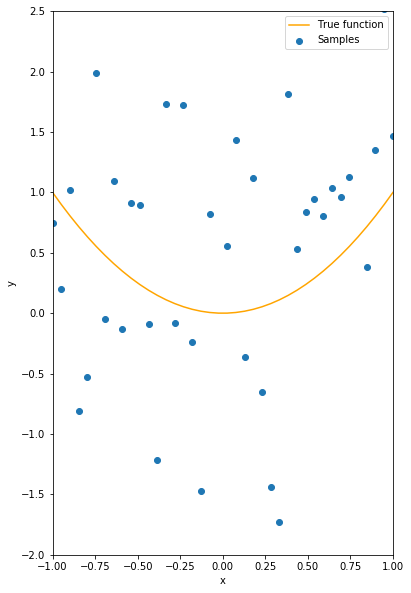

In [3]:
data_set=Data()
data_set.plot()

Get some validation data: 

In [4]:
torch.manual_seed(0) 
validation_set=Data(train=False)

<a id="ref1"></a>
<h2 align=center>Create the Model, Optimizer, and Total Loss Function (cost)</h2>

Create a custom module with three layers. <code>in_size</code> is the size of the input features, <code>n_hidden</code> is the size of the layers, and <code>out_size</code> is the size. <code>p</code> is dropout probability. The default is 0 , that is, no dropout.


In [5]:
class Net(nn.Module):
    def __init__(self,in_size,n_hidden,out_size,p=0):

        super(Net,self).__init__()
        self.drop=nn.Dropout(p=p)
        self.linear1=nn.Linear(in_size,n_hidden)
        self.linear2=nn.Linear(n_hidden,n_hidden)
        self.linear3=nn.Linear(n_hidden,out_size)
        
    def forward(self,x):
        x=F.relu(self.linear1(x))
        x=self.drop(x)
        x=F.relu(self.linear2(x))
        x=self.drop(x)
        x=self.linear3(x)
        return x

Create two model objects: model had no dropout, and model_drop has a dropout probability of 0.5:

In [6]:
model=Net(1,300,1)
model_drop=Net(1,300,1,p=0.5)

<a id="ref2"></a>
<h2 align=center>Train the Model via Mini-Batch Gradient Descent </h2>

Set the model using dropout to training mode; this is the default mode, but it's a good practice. 

In [7]:
model_drop.train()

Net(
  (drop): Dropout(p=0.5)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

Train the model by using the Adam optimizer. See the unit on other optimizers. Use the mean square loss: 

In [8]:
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

Initialize a dictionary that stores the training and validation loss for each model:

In [9]:
LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

Run 500 iterations of batch gradient decent: 

In [10]:
epochs=500

for epoch in range(epochs):
    #make a prediction for both models 
    yhat = model(data_set.x)
    yhat_drop = model_drop(data_set.x)
    #calculate the lossf or both models 
    loss = criterion(yhat, data_set.y)
    loss_drop = criterion(yhat_drop, data_set.y)
    
    #store the loss for  both the training and validation  data for both models 
    LOSS['training data no dropout'].append(loss.item())
    LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
    LOSS['training data dropout'].append(loss_drop.item())
    model_drop.eval()
    LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
    model_drop.train()
    
    #clear gradient 
    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    #Backward pass: compute gradient of the loss with respect to all the learnable parameters
    loss.backward()
    loss_drop.backward()
    #the step function on an Optimizer makes an update to its parameters
    optimizer_ofit.step()
    optimizer_drop.step()

Set the model with dropout to evaluation mode:

In [11]:
model_drop.eval()

Net(
  (drop): Dropout(p=0.5)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

Make a prediction by using both models: 

In [12]:
yhat=model(data_set.x)
yhat_drop=model_drop(data_set.x)

Plot predictions of both models. Compare them to the training points and the true function: 

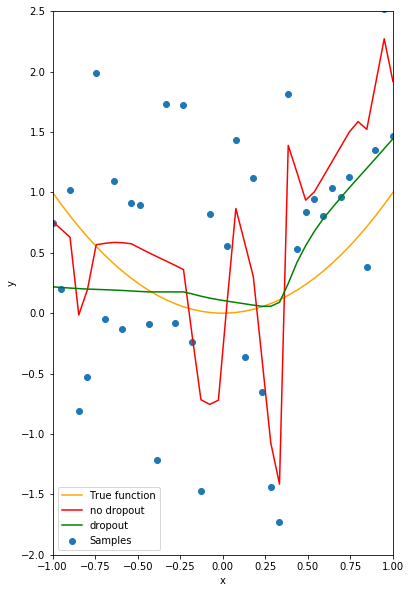

In [13]:
plt.figure(figsize=(6.1, 10))

plt.scatter(data_set.x.numpy(), data_set.y.numpy(), label="Samples")
plt.plot(data_set.x.numpy(), data_set.f.numpy()  ,label="True function",color='orange')
plt.plot(data_set.x.numpy(),yhat.detach().numpy(),label='no dropout',c='r')
plt.plot(data_set.x.numpy(),yhat_drop.detach().numpy(),label="dropout",c='g')


plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc="best")
plt.show()

You can see that the model using dropout does better at tracking the function that generated the data. 

Plot out the loss for training and validation data on both models:  

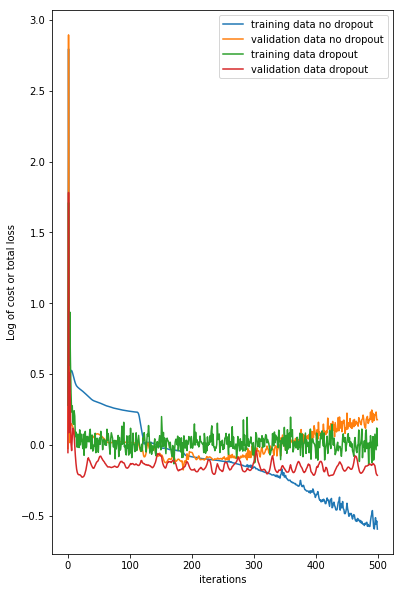

In [14]:
plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)),label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")

You see that the model without dropout performs better on the training data, but it performs worse on the validation data. This suggests overfitting.  However, the model using dropout performs better on the validation data, but worse on the training data. 

<div class="alert alert-block alert-info" style="margin-top: 20px">
 <a href="http://cocl.us/pytorch_link_bottom"><img src = "http://cocl.us/pytorch_image_bottom" width = 950, align = "center"></a>

### About the Authors:  

 [Joseph Santarcangelo]( https://www.linkedin.com/in/joseph-s-50398b136/) has a PhD in Electrical Engineering. His research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. 

Other contributors: [Michelle Carey](  https://www.linkedin.com/in/michelleccarey/), [Morvan Youtube channel]( https://www.youtube.com/channel/UCdyjiB5H8Pu7aDTNVXTTpcg), [Mavis Zhou](  https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a/)

<hr>

Copyright &copy; 2018 [cognitiveclass.ai](cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).